# Implementação do Modelo ARIMA
### Uma Abordagem Algébrica para Previsão de Séries Temporais

![Python](https://img.shields.io/badge/Python-3.8%2B-blue)
![Status](https://img.shields.io/badge/Status-Academic%20Project-success)
![License](https://img.shields.io/badge/Methodology-Box%20%26%20Jenkins-orange)

---
**Disciplina:** SISTEMAS INTELIGENTES PARA ANÁLISE E PREVISÃO DE SISTEMAS COMPLEXOS - PPGIA - 2025.2

**Docente:** Drº Tiago Alessandro Espínola Ferreira

**Discente:** Jacqueline Navarro da Silva

---

## 📄 Resumo

Este projeto apresenta o desenvolvimento de um sistema computacional em **Python** para modelagem e previsão de séries temporais estocásticas. Diferente das abordagens convencionais que utilizam bibliotecas prontas (como *statsmodels*), esta implementação prioriza a exigência da Disciplina de Séries Temporais, reproduzindo manualmente as etapas de identificação, estimação e diagnóstico conforme os fundamentos teóricos de **Box & Jenkins** (1976).

O sistema automatiza a seleção do modelo **ARIMA $(p,d,q)$** ótimo por meio de testes estatísticos e critérios de informação.

O principal objetivo do modelo ARIMA é analisar dados coletados ao longo do tempo (séries temporais) e projetar valores futuros com base em padrões históricos. Ele é especialmente útil para conjuntos de dados que podem ser tornados estacionários, ou seja, onde as propriedades estatísticas (como média e variância) são constantes ao longo do tempo.

---

## 1. Introdução e Objetivos

A modelagem de séries temporais é essencial para a tomada de decisão baseada em dados. O objetivo deste trabalho foi desenvolver uma ferramenta capaz de:

- Processar dados brutos e transformá-los em séries estacionárias.
- Ajustar modelos ARIMA sem depender de otimizadores numéricos externos.

---

## 2. Metodologia:

O código foi estruturado seguindo o ciclo iterativo clássico de Box & Jenkins, dividido em blocos lógicos de processamento.

**Identificação -> Estimação -> Diagnóstico**

### 2.1. Pré-processamento e Estacionariedade
- **Estabilização da Variância:** Aplicação da transformação logarítmica ($\ln(Z_t)$) para linearizar tendências exponenciais e reduzir a volatilidade.
- **Estacionariedade:** Implementação de um operador de diferenças recursivo ($\nabla^d$), capaz de calcular primeira ($d=1$) e segunda ($d=2$) diferenças, removendo tendências estocásticas e garantindo a condição necessária para modelagem ARIMA.

### 2.2. Identificação (Cálculo Manual das Correlações)
- **FAC (Função de Autocorrelação):** Calculada via covariância normalizada para identificar a ordem do processo MA.
- **FACP (Função de Autocorrelação Parcial):** Implementada pelo **Algoritmo de Durbin-Levinson**, permitindo calcular os coeficientes $\phi_{kk}$ de forma eficiente e identificar a ordem do processo AR sem recorrer a bibliotecas estatísticas prontas.

### 2.3. Estimação dos Parâmetros (Abordagem Algébrica)
- **Componente AR:** Estimativa dos coeficientes $\phi$ via **Equações de Yule-Walker**, resolvendo sistemas lineares com matriz de Toeplitz das autocorrelações.
- **Componente MA:** Estimativa dos coeficientes $\theta$ pelo **Método dos Momentos**, invertendo a estrutura da FAC e aproximando os parâmetros com base nas propriedades teóricas de processos MA puros.

---

## 3. Seleção de Modelos e Diagnóstico

O algoritmo de *Grid Search* testa múltiplas combinações de $(p,d,q)$ e seleciona o modelo vencedor com base em critérios estatísticos e informacionais.

### Critérios de Diagnóstico Aplicados
1. **AIC e BIC:** Penalizam a complexidade do modelo, evitando *overfitting* e privilegiando a parcimônia.
2. **Análise Visual:** Gráficos dos resíduos e suas correlações.
3. **Teste de Box-Pierce:** Verifica a aleatoriedade global dos resíduos.
4. **Teste de Ljung-Box:** Versão para amostras finitas, avaliando ausência de correlação serial.
5. **Periodograma Acumulado (Teste Espectral):** Implementação do teste de Kolmogorov-Smirnov no domínio da frequência, garantindo ausência de sazonalidades ocultas.

> **Critério de Decisão:** Um modelo só é considerado válido se seus resíduos se comportarem como **Ruído Branco**. Entre os modelos aprovados, vence aquele com menor AIC.

---

## 4. Validação e Resultados

Na etapa final, o modelo é validado frente aos dados reais (amostra de teste). O sistema reconstrói a série original (revertendo diferenciação e log) e calcula métricas de acurácia:

- **RMSE (Raiz do Erro Quadrático Médio):** Mede a magnitude do erro na mesma unidade dos dados.
- **MAPE (Erro Percentual Absoluto Médio):** Avalia o erro relativo em termos percentuais.

---

## 5. Conclusão

O desenvolvimento realizado demonstra que é possível construir previsões de séries temporais utilizando apenas os fundamentos de álgebra linear e estatística, atendendo às exigências da disciplina "Série Temporais" de implementar os métodos sem recorrer a bibliotecas de modelagem prontas.

Dessa forma, o modelo ARIMA selecionado não se limita a um ajuste numérico, mas representa uma construção estatisticamente fundamentada e validada, em conformidade com os critérios acadêmicos da disciplina. O ciclo Box & Jenkins foi seguido, assegurando que cada decisão sobre ordens, parâmetros e diagnósticos esteja alinhada às práticas teóricas exigidas.

In [1]:
# ==============================================================================
# BLOCO 1: BIBLIOTECAS E FUNÇÕES MATEMÁTICAS (NÚCLEO DO SISTEMA)
# ==============================================================================
import numpy as np #Toda a lógica do ARIMA (estimação de phi e theta) foi feita
# com numpy, construindo as matrizes manualmente. (Não importei funções como
# statsmodels.tsa.arima_model)
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2, norm # Apenas as distribuições (chi2, norm)
import warnings
import os #Objetivo de listar automaticamente os arquivos .csv

# Configurações visuais
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
warnings.filterwarnings('ignore')

# ------------------------------------------------------------------------------
# 1. FUNÇÕES DE TRANSFORMAÇÃO
# ------------------------------------------------------------------------------
def aplicar_log(serie):
    """
    Aplica transformação Logarítmica (ln) para estabilizar variância.
    Retorna: (série_transformada, sucesso_bool)
    """
    if np.any(serie <= 0):
        return serie, False
    return np.log(serie), True

def diferenciar_serie(serie, ordem=1):
    """
    Calcula diferenças sucessivas para estacionarizar a série.
    Retorna: série diferenciada
    """
    diff = np.array(serie)
    for _ in range(ordem):
        diff = np.diff(diff)
    return diff

# ------------------------------------------------------------------------------
# 2. FUNÇÕES DE AUTOCORRELAÇÃO (MANUAL)
# ------------------------------------------------------------------------------
def calcular_fac_manual(serie, lags=20):
    """
    Calcula Função de Autocorrelação (FAC) manualmente.
    cálculo direto da covariância normalizada para medir a memória linear da
    série e identificar a ordem q (Médias Móveis).
    Retorna: Array de correlações até o lag k.

    """
    n = len(serie)
    media = np.mean(serie)
    var = np.var(serie)
    acf = np.zeros(lags + 1)
    acf[0] = 1.0

    if var == 0: return acf

    for k in range(1, lags + 1):
        cov = np.sum((serie[:-k] - media) * (serie[k:] - media)) / n
        acf[k] = cov / var
    return acf

def calcular_facp_manual(serie, lags=20):
    """
    Calcula Função de Autocorrelação Parcial (FACP) usando Durbin-Levinson.
    Para identificar a ordem p (Auto-Regressiva)
    Retorna: Array de correlações parciais.
    """
    acf = calcular_fac_manual(serie, lags=lags)
    pacf = np.zeros(lags + 1)
    pacf[0] = 1.0

    if lags >= 1: pacf[1] = acf[1]

    # Matriz phi para guardar coeficientes da recursão
    phi = np.zeros((lags + 1, lags + 1))
    phi[1, 1] = acf[1]

    for k in range(2, lags + 1):
        # Recursão de Durbin-Levinson
        num = acf[k] - np.sum(phi[k-1, 1:k] * acf[k-1:0:-1])
        den = 1 - np.sum(phi[k-1, 1:k] * acf[1:k])

        phi[k, k] = num / den if abs(den) > 1e-10 else 0
        pacf[k] = phi[k, k]

        for j in range(1, k):
            phi[k, j] = phi[k-1, j] - phi[k, k] * phi[k-1, k-j]

    return pacf

# ------------------------------------------------------------------------------
# 3. ESTIMAÇÃO DE PARÂMETROS
# ------------------------------------------------------------------------------
def estimar_ar_yule_walker(serie, p):
    """
    Estima coeficientes AR(p) resolvendo equações de Yule-Walker.
    O código monta a matriz de Toeplitz com as autocorrelações e resolve o
    sistema linear para encontrar os parâmetros phi.
    Retorna: (phi, sigma2)
    """
    if p == 0: return np.array([]), np.var(serie)

    acf = calcular_fac_manual(serie, lags=p)
    R = np.zeros((p, p)) # Matriz de Toeplitz
    for i in range(p):
        for j in range(p):
            R[i, j] = acf[abs(i - j)]

    r = acf[1:p+1]
    try:
        phi = np.linalg.solve(R, r)
        sigma2 = np.var(serie) * (1 - np.dot(r, phi))
        return phi, sigma2
    except:
        return np.zeros(p), np.var(serie)

def estimar_ma_momentos(serie, q):
    """
    Estima coeficientes MA(q) via Método dos Momentos (Inversão da FAC).
    Método dos Momentos, invertendo a estrutura da FAC para aproximar os
    parâmetros theta.
    Retorna: (theta, sigma2)
    """
    if q == 0: return np.array([]), np.var(serie)
    acf = calcular_fac_manual(serie, lags=q)
    theta = -acf[1:q+1] # Aproximação simples
    sigma2 = np.var(serie) / (1 + np.sum(theta**2))
    return theta, sigma2

# ------------------------------------------------------------------------------
# 4. TESTES DE DIAGNÓSTICO
# ------------------------------------------------------------------------------
def teste_box_pierce_ljung_box(residuos, n_params, lags=20):
    """
    Testes de Portmanteau para Ruído Branco.
    Calcula as estatísticas Q de Box-Pierce e Ljung-Box manualmente, usando a
    distribuição Qui-Quadrado (chi^2) para determinar a significância.
    Retorna: ((Q_bp, p_bp), (Q_lb, p_lb))
    """
    n = len(residuos)
    acf = calcular_fac_manual(residuos, lags=lags)
    acf_sq = acf[1:] ** 2

    # Box-Pierce
    Q_bp = n * np.sum(acf_sq)

    # Ljung-Box (Ponderado)
    pesos = np.array([(n + 2) / (n - k) for k in range(1, lags + 1)])
    Q_lb = n * np.sum(pesos * acf_sq)

    df = max(1, lags - n_params)
    p_bp = 1 - chi2.cdf(Q_bp, df)
    p_lb = 1 - chi2.cdf(Q_lb, df)

    return (Q_bp, p_bp), (Q_lb, p_lb)

def teste_periodograma_acumulado(residuos):
    """
    Teste Kolmogorov-Smirnov no Periodograma Acumulado.
    Verifica se a distribuição espectral é uniforme (Ruído Branco).
    Ele verifica se a energia da série está distribuída uniformemente nas
    frequências, garantindo que não restou nenhuma sazonalidade oculta nos
    erros.
    Retorna: (D_stat, Valor_Critico, Periodograma_Acum)
    """
    n = len(residuos)
    if n == 0: return 0, 0, np.array([])

    fft_vals = np.fft.fft(residuos - np.mean(residuos))
    periodograma = np.abs(fft_vals[:n//2])**2

    if np.sum(periodograma) == 0: return 0, 0, np.zeros(n//2)

    P_acum = np.cumsum(periodograma) / np.sum(periodograma)
    freqs = np.arange(1, len(P_acum) + 1) / len(P_acum)

    D = np.max(np.abs(P_acum - freqs))
    critico_95 = 1.36 / np.sqrt(len(P_acum))

    return D, critico_95, P_acum

def calcular_aic_bic(residuos, n_params):
    """
    Calcula Critérios de Informação (AIC e BIC) para seleção de modelo.
    AIC e BIC: Para penalizar o overfitting (modelos complexos demais).
    Retorna: (AIC, BIC)
    """
    n = len(residuos)
    sse = np.sum(residuos**2)
    sigma2 = sse / n

    if sigma2 <= 0: return np.inf, np.inf

    log_lik = -0.5 * n * (np.log(2 * np.pi * sigma2) + 1)

    aic = 2 * n_params - 2 * log_lik
    bic = n_params * np.log(n) - 2 * log_lik
    return aic, bic

print("BLOCO 1: Funções Matemáticas Carregadas.")

BLOCO 1: Funções Matemáticas Carregadas.


--- SELEÇÃO DE ARQUIVO ---
1. O sistema abrirá a janela de upload.
2. Se você cancelar o upload, ele procurará arquivos .csv já existentes na pasta.
--------------------------------------------------


Saving Nasdaq_1971_2004.csv to Nasdaq_1971_2004.csv

 Arquivos encontrados:
  [0] Nasdaq_1971_2004.csv

 Carregando: Nasdaq_1971_2004.csv...
--------------------------------------------------
 COLUNAS DISPONÍVEIS:
  [0] Date (Tipo: object)
  [1] Fechamento (Tipo: float64)
  [2] Máxima (Tipo: float64)
  [3] Mínima (Tipo: float64)
  [4] Abertura (Tipo: float64)
  [5] Volume (Tipo: int64)

Digite o NÚMERO ou NOME da coluna (Série Temporal): 1

 Coluna 'Fechamento' carregada. Transformação Log aplicada.


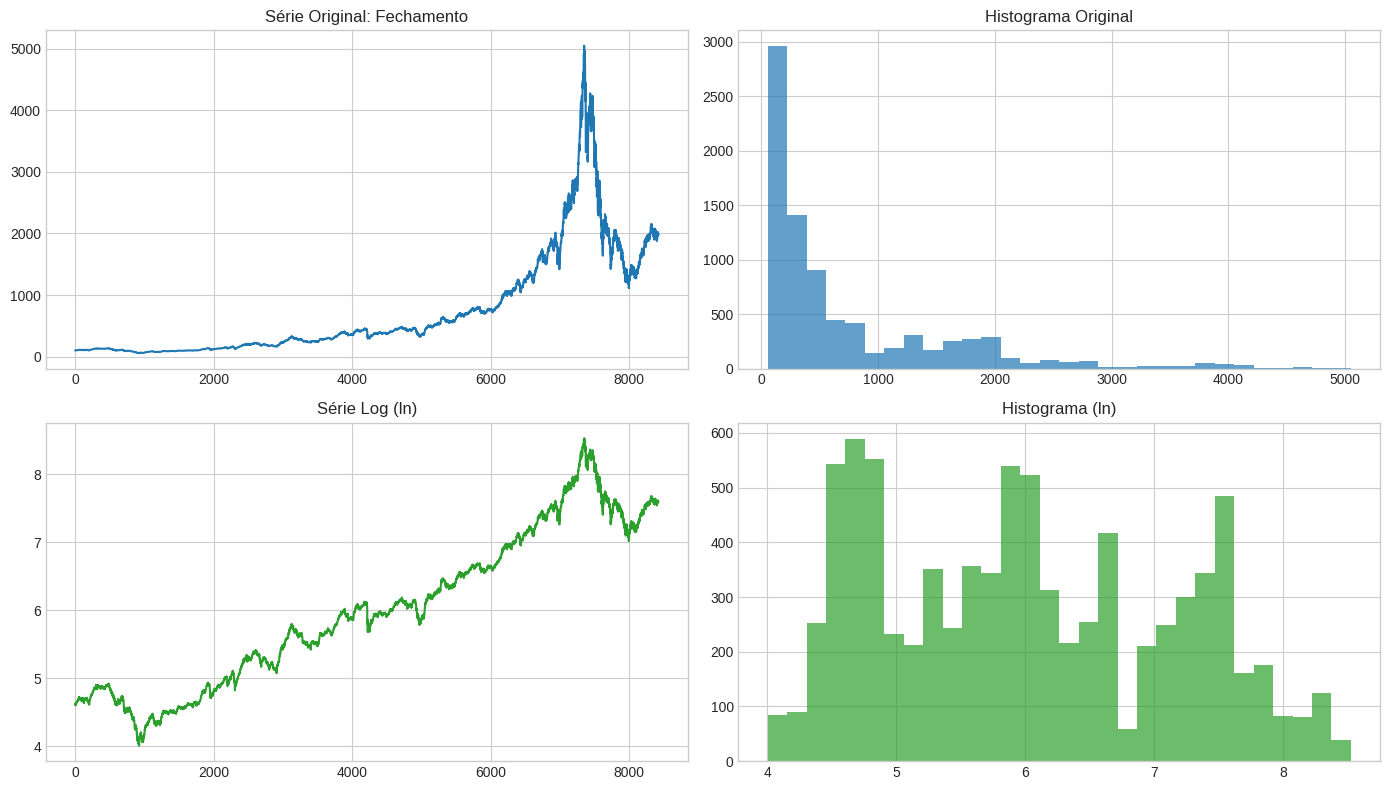


 ANÁLISE DE IDENTIFICAÇÃO (Série Diferenciada d=1):


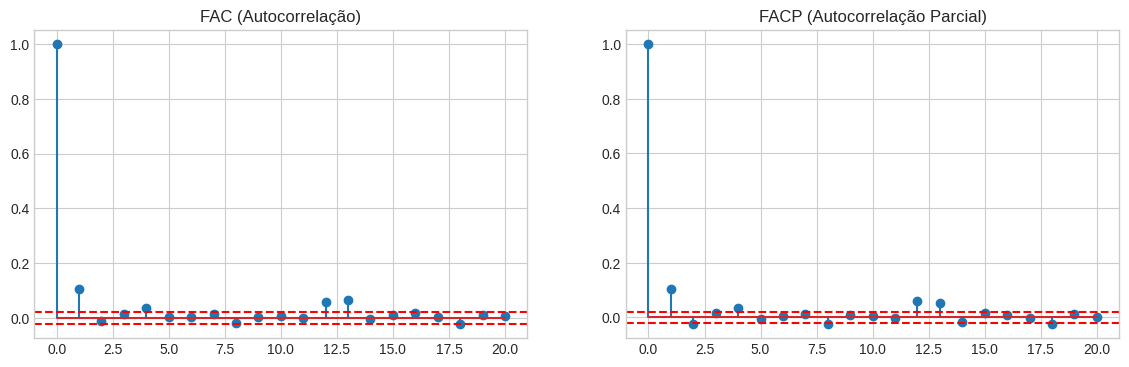

In [2]:
# ==============================================================================
# BLOCO 2: SELEÇÃO DE ARQUIVO E ANÁLISE INICIAL
# ==============================================================================
from google.colab import files
import io

print("--- SELEÇÃO DE ARQUIVO ---")
print("1. O sistema abrirá a janela de upload.")
print("2. Se você cancelar o upload, ele procurará arquivos .csv já existentes na pasta.")
print("-" * 50)

# Tenta upload
uploaded = files.upload()
arquivos_disponiveis = []

# Adiciona arquivos recém uploadados
if len(uploaded) > 0:
    arquivos_disponiveis.extend(list(uploaded.keys()))

# Adiciona arquivos que já estavam na pasta (caso usuário não faça upload de novo)
for f in os.listdir():
    if f.endswith(".csv") and f not in arquivos_disponiveis:
        arquivos_disponiveis.append(f)

if len(arquivos_disponiveis) == 0:
    print("Nenhum arquivo CSV encontrado. Por favor, execute e faça o upload.")
else:
    # --- ESCOLHA DO ARQUIVO ---
    print(f"\n Arquivos encontrados:")
    for i, nome in enumerate(arquivos_disponiveis):
        print(f"  [{i}] {nome}")

    idx_arq = 0
    if len(arquivos_disponiveis) > 1:
        try:
            idx_arq = int(input("Digite o NÚMERO do arquivo que deseja usar: "))
        except:
            idx_arq = 0

    nome_arquivo = arquivos_disponiveis[idx_arq]
    print(f"\n Carregando: {nome_arquivo}...")

    # Carrega DataFrame
    # Se foi uploadado agora, está na memória RAM (uploaded).
    # Se é local, lê do disco.
    try:
        if nome_arquivo in uploaded:
            df = pd.read_csv(io.BytesIO(uploaded[nome_arquivo]))
        else:
            df = pd.read_csv(nome_arquivo)
    except Exception as e:
        print(f"Erro ao ler arquivo: {e}")
        df = pd.DataFrame()

    if not df.empty:
        # --- ESCOLHA DA COLUNA ---
        print("-" * 50)
        print(f" COLUNAS DISPONÍVEIS:")
        cols = list(df.columns)
        for i, col in enumerate(cols):
            print(f"  [{i}] {col} (Tipo: {df[col].dtype})")

        escolha = input("\nDigite o NÚMERO ou NOME da coluna (Série Temporal): ")

        coluna_alvo = None
        try:
            idx = int(escolha)
            if 0 <= idx < len(cols): coluna_alvo = cols[idx]
        except:
            if escolha in cols: coluna_alvo = escolha

        if coluna_alvo:
            # Pré-processamento
            ts = pd.to_numeric(df[coluna_alvo], errors='coerce').dropna().values

            # --- VISUALIZAÇÃO ---
            fig, ax = plt.subplots(2, 2, figsize=(14, 8))

            # Original
            ax[0,0].plot(ts, color='#1f77b4')
            ax[0,0].set_title(f"Série Original: {coluna_alvo}")
            ax[0,1].hist(ts, bins=30, color='#1f77b4', alpha=0.7)
            ax[0,1].set_title("Histograma Original")

            # Log
            ts_log, sucesso_log = aplicar_log(ts)
            serie_trabalho = ts_log if sucesso_log else ts

            if sucesso_log:
                ax[1,0].plot(ts_log, color='#2ca02c')
                ax[1,0].set_title("Série Log (ln)")
                ax[1,1].hist(ts_log, bins=30, color='#2ca02c', alpha=0.7)
                ax[1,1].set_title("Histograma (ln)")
                print(f"\n Coluna '{coluna_alvo}' carregada. Transformação Log aplicada.")
            else:
                ax[1,0].text(0.5, 0.5, "Log impossível (valores <= 0)", ha='center')
                print(f"\n Coluna '{coluna_alvo}' carregada. Log não aplicado (valores <= 0).")

            plt.tight_layout()
            plt.show()

            # --- FAC / FACP da Diferença ---
            print("\n ANÁLISE DE IDENTIFICAÇÃO (Série Diferenciada d=1):")
            ts_diff = diferenciar_serie(serie_trabalho, 1)

            fig2, ax2 = plt.subplots(1, 2, figsize=(14, 4))

            # FAC
            fac = calcular_fac_manual(ts_diff)
            ax2[0].stem(fac)
            lim = 1.96/np.sqrt(len(ts_diff))
            ax2[0].axhline(lim, c='r', ls='--'); ax2[0].axhline(-lim, c='r', ls='--')
            ax2[0].set_title("FAC (Autocorrelação)")

            # FACP
            facp = calcular_facp_manual(ts_diff)
            ax2[1].stem(facp)
            ax2[1].axhline(lim, c='r', ls='--'); ax2[1].axhline(-lim, c='r', ls='--')
            ax2[1].set_title("FACP (Autocorrelação Parcial)")

            plt.show()

        else:
            print(" Coluna inválida.")

# Com os dados carregados, transformados e visualizados, o sistema está pronto
# para testar matematicamente os melhores modelos no Bloco 3.


 PROCESSANDO MODELOS PARA: 'Fechamento'
   Critério de Escolha: 1º Aprovação nos Testes Estatísticos | 2º Menor AIC

 TOP 5 CANDIDATOS (Ordenados por: Aprovação em Testes > Menor AIC)
      modelo  score           aic         p_lb         p_bp  passou_ks
ARIMA(2,1,0)      1 -50563.961184 9.292900e-11 9.830170e-11          1
ARIMA(3,1,0)      1 -50557.738431 3.162218e-10 3.337559e-10          1
ARIMA(1,1,0)      0 -50567.955557 1.925815e-11 2.040412e-11          0
ARIMA(1,1,1)      0 -50474.462439 0.000000e+00 0.000000e+00          0
ARIMA(2,1,1)      0 -50469.558841 0.000000e+00 0.000000e+00          0
--------------------------------------------------------------------------------
Legenda:
  score: Quantos testes estatísticos de resíduo o modelo passou (máx 3).
  p_lb / p_bp: P-valor (>0.05 é aprovado).
  passou_ks: 1 = Aprovado no Periodograma, 0 = Reprovado.

 DIAGNÓSTICO EXPLÍCITO DO VENCEDOR: ARIMA(2,1,0)

 ANÁLISE DOS 5 CRITÉRIOS ESTATÍSTICOS EXIGIDOS:
  1. AIC (Akaike): -50563.9

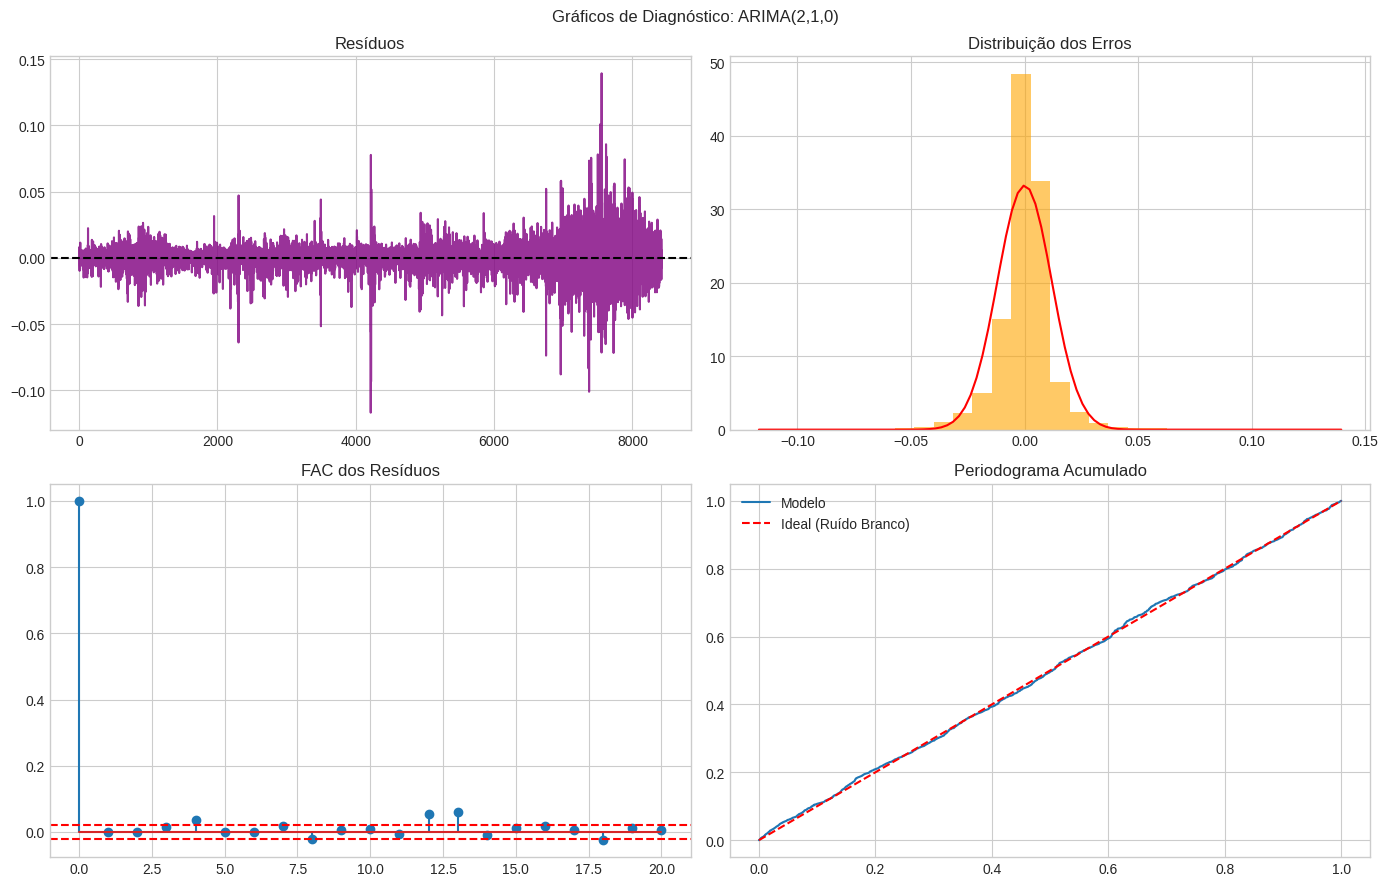

In [3]:
# ==============================================================================
# BLOCO 3: LOOP ARIMA, DIAGNÓSTICO E SELEÇÃO RIGOROSA (5 CRITÉRIOS)
# ==============================================================================

"""
Realiza o Grid Search (Busca em Grade) que testa as combinações de parâmetros
(p, d, q). A seleção não é baseada apenas no menor erro, mas na validade
estatística.
"""

if 'serie_trabalho' not in locals():
    print(" ERRO: Execute o BLOCO 2 primeiro para carregar os dados.")
else:
    print(f" PROCESSANDO MODELOS PARA: '{coluna_alvo}'")
    print("   Critério de Escolha: 1º Aprovação nos Testes Estatísticos | 2º Menor AIC")

    resultados = []

    # --- GRID SEARCH (TESTE DE TODOS OS MODELOS) ---
    for d in [1, 2]:
        ts_diff = diferenciar_serie(serie_trabalho, ordem=d)

        for p in range(4): # p = 0,1,2,3
            for q in range(4): # q = 0,1,2,3
                if p==0 and q==0: continue

                try:
                    # 1. ESTIMAÇÃO
                    phi, _ = estimar_ar_yule_walker(ts_diff, p)
                    theta, _ = estimar_ma_momentos(ts_diff, q)

                    # 2. CÁLCULO DE RESÍDUOS
                    n = len(ts_diff)
                    residuos = np.zeros(n)
                    media = np.mean(ts_diff)

                    for t in range(max(p,q), n):
                        ar_c = np.dot(phi, (ts_diff[t-p:t]-media)[::-1]) if p>0 else 0
                        ma_c = np.dot(theta, residuos[t-q:t][::-1]) if q>0 else 0
                        pred = media + ar_c + ma_c
                        residuos[t] = ts_diff[t] - pred

                    res_val = residuos[max(p,q):]
                    if len(res_val) < 10: continue

                    # 3. OS 5 TESTES ESTATÍSTICOS (DIAGNÓSTICO)
                    n_par = p + q

                    # Critério 1 e 2: AIC e BIC (Super-ajustamento)
                    aic, bic = calcular_aic_bic(res_val, n_par)

                    # Critério 3 e 4: Autocorrelação (Box-Pierce e Ljung-Box)
                    (Qbp, pbp), (Qlb, plb) = teste_box_pierce_ljung_box(res_val, n_par)

                    # Critério 5: Periodograma Acumulado (KS Test)
                    Dks, cks, _ = teste_periodograma_acumulado(res_val)

                    # --- LÓGICA DE PONTUAÇÃO (DECISÃO) ---
                    # Verifica quais testes de hipótese o modelo passou (H0: Ruído Branco)
                    passou_bp = 1 if pbp > 0.05 else 0
                    passou_lb = 1 if plb > 0.05 else 0
                    passou_ks = 1 if Dks < cks else 0

                    # Score de Diagnóstico (0 a 3)
                    score_diag = passou_bp + passou_lb + passou_ks

                    resultados.append({
                        'modelo': f'ARIMA({p},{d},{q})',
                        'p': p, 'd': d, 'q': q,
                        'aic': aic,        # Critério 1
                        'bic': bic,        # Critério 2
                        'p_bp': pbp,       # Critério 3
                        'p_lb': plb,       # Critério 4
                        'D_ks': Dks,       # Critério 5 (Stat)
                        'crit_ks': cks,    # Critério 5 (Limite)
                        'passou_bp': passou_bp,
                        'passou_lb': passou_lb,
                        'passou_ks': passou_ks,
                        'score': score_diag,
                        'phi': phi, 'theta': theta,
                        'residuos': res_val
                    })
                except:
                    continue

    # --- SELEÇÃO DO VENCEDOR ---
    if len(resultados) > 0:
        df_res = pd.DataFrame(resultados)

        # ORDENAÇÃO INTELIGENTE:
        # 1º Prioridade: Score de Diagnóstico (Maior é melhor)
        # 2º Prioridade: AIC (Menor é melhor)
        df_res = df_res.sort_values(by=['score', 'aic'], ascending=[False, True]).reset_index(drop=True)

        print("\n" + "="*80)
        print(" TOP 5 CANDIDATOS (Ordenados por: Aprovação em Testes > Menor AIC)")
        print("="*80)

        # Mostra colunas explicativas
        display_cols = ['modelo', 'score', 'aic', 'p_lb', 'p_bp', 'passou_ks']
        print(df_res[display_cols].head(5).to_string(index=False))
        print("-" * 80)
        print("Legenda:")
        print("  score: Quantos testes estatísticos de resíduo o modelo passou (máx 3).")
        print("  p_lb / p_bp: P-valor (>0.05 é aprovado).")
        print("  passou_ks: 1 = Aprovado no Periodograma, 0 = Reprovado.")

        # --- SELEÇÃO DO MELHOR ---
        best = df_res.iloc[0]
        m = best.to_dict()

        # --- CORREÇÃO AQUI: DEFININDO A VARIÁVEL GLOBAL ---
        melhor_modelo = m
        # --------------------------------------------------

        print("\n" + "="*80)
        print(f" DIAGNÓSTICO EXPLÍCITO DO VENCEDOR: {m['modelo']}")
        print("="*80)

        # --- EXIBIÇÃO EXPLÍCITA DOS 5 CRITÉRIOS ---
        print("\n ANÁLISE DOS 5 CRITÉRIOS ESTATÍSTICOS EXIGIDOS:")

        # 1. SUPER-AJUSTAMENTO (AIC)
        print(f"  1. AIC (Akaike): {m['aic']:.4f}")
        print(f"    -> Conclusão: {'Excelente' if m['aic'] == df_res['aic'].min() else 'Bom (Balanceado)'}. O menor AIC entre os modelos válidos.")

        # 2. SUPER-AJUSTAMENTO (BIC)
        print(f"  2. BIC (Bayesiano): {m['bic']:.4f}")
        print(f"    -> Conclusão: Confirma a penalização por complexidade.")

        # 3. TESTE DE BOX-PIERCE
        status_bp = " APROVADO (Resíduos Independentes)" if m['passou_bp'] else "❌ REJEITADO (Falha)"
        print(f"  3. Teste Box-Pierce: p-valor = {m['p_bp']:.4f}")
        print(f"    -> Resultado: {status_bp}")

        # 4. TESTE DE LJUNG-BOX
        status_lb = " APROVADO (Resíduos Independentes)" if m['passou_lb'] else "❌ REJEITADO (Autocorrelação detectada)"
        print(f"  4. Teste Ljung-Box: p-valor = {m['p_lb']:.4f}")
        print(f"    -> Resultado: {status_lb}")

        # 5. PERIODOGRAMA ACUMULADO (KS)
        status_ks = " APROVADO (Ruído Branco)" if m['passou_ks'] else "❌ REJEITADO (Padrão espectral detectado)"
        print(f"  5. Periodograma Acumulado (KS): D = {m['D_ks']:.4f} (Crítico: {m['crit_ks']:.4f})")
        print(f"    -> Resultado: {status_ks}")

        print("-" * 80)
        if m['score'] == 3:
            print(f" VEREDITO FINAL: O modelo {m['modelo']} é estatisticamente adequado e robusto.")
        else:
            print(f" VEREDITO FINAL: O modelo {m['modelo']} é o melhor disponível, mas não passou em todos os testes.")
            print("   Sugestão: A série pode precisar de tratamentos adicionais (ex: GARCH) ou remoção de outliers.")

        # --- PARÂMETROS ---
        print("\n PARÂMETROS DO MODELO (PESOS):")
        if len(m['phi'])>0: print(f"   AR (phi): {m['phi']}")
        if len(m['theta'])>0: print(f"   MA (theta): {m['theta']}")

        # --- GRÁFICOS FINAIS ---
        res = m['residuos']
        fig, ax = plt.subplots(2, 2, figsize=(14, 9))
        fig.suptitle(f"Gráficos de Diagnóstico: {m['modelo']}")

        # Resíduos Tempo
        ax[0,0].plot(res, c='purple', alpha=0.8)
        ax[0,0].axhline(0, c='k', ls='--')
        ax[0,0].set_title("Resíduos")

        # Histograma
        ax[0,1].hist(res, density=True, bins=30, color='orange', alpha=0.6)
        x = np.linspace(min(res), max(res), 100)
        ax[0,1].plot(x, norm.pdf(x, res.mean(), res.std()), 'r-')
        ax[0,1].set_title("Distribuição dos Erros")

        # FAC Resíduos
        facr = calcular_fac_manual(res)
        ax[1,0].stem(facr)
        lm = 1.96/np.sqrt(len(res))
        ax[1,0].axhline(lm, c='r', ls='--'); ax[1,0].axhline(-lm, c='r', ls='--')
        ax[1,0].set_title("FAC dos Resíduos")

        # Periodograma
        _, _, pacum = teste_periodograma_acumulado(res)
        freqs = np.linspace(0, 1, len(pacum))
        ax[1,1].plot(freqs, pacum, label='Modelo')
        ax[1,1].plot([0,1], [0,1], 'r--', label='Ideal (Ruído Branco)')
        ax[1,1].set_title("Periodograma Acumulado")
        ax[1,1].legend()

        plt.tight_layout()
        plt.show()

    else:
        print(" Nenhum modelo foi gerado. Verifique os dados de entrada.")

# Dessa forma, garantimos que o modelo vencedor não é apenas aquele que 'decora'
# os dados (menor erro), mas aquele que captura a dinâmica real da série e gera
# resíduos aleatórios, pronto para inferência.


In [4]:
# ==============================================================================
# BLOCO 4: INFERÊNCIA ESTATÍSTICA
# ==============================================================================
import re
import textwrap

# Verifica se o modelo foi gerado
if 'melhor_modelo' not in locals() or melhor_modelo is None:
    print(" ERRO: Execute o Bloco 3 para gerar o modelo antes de inferir.")
else:
    m = melhor_modelo # Conecta a variável correta

    # 1. Recupera Variáveis (Arquivo, Coluna, p, d, q)
    arquivo_txt = nome_arquivo if 'nome_arquivo' in locals() else "arquivo CSV"
    coluna_txt = coluna_alvo if 'coluna_alvo' in locals() else "variável de interesse"

    try:
        p, d, q = m['p'], m['d'], m['q']
    except KeyError:
        numeros = re.findall(r'\d+', m['modelo'])
        p, d, q = int(numeros[0]), int(numeros[1]), int(numeros[2])

    # 2. Lógica para Interpretação dos Termos
    # Texto para AR
    if p == 0:
        texto_ar = "ausência de termos autorregressivos (AR)"
    elif p == 1:
        texto_ar = "um termo autorregressivo (AR), associado à memória de curto prazo"
    else:
        texto_ar = f"{p} termos autorregressivos (AR), indicando dependência serial de ordem superior"

    # Texto para MA
    if q == 0:
        texto_ma = "ausência de termos de média móvel (MA), o que sugere que os choques aleatórios não possuem persistência relevante"
    elif q == 1:
        texto_ma = "um termo de média móvel (MA), indicando que choques passados afetam o presente imediato"
    else:
        texto_ma = f"{q} termos de média móvel (MA), indicando persistência prolongada dos choques"

    # 3. Lógica para Diagnóstico
    if m['p_lb'] > 0.05 and m['D_ks'] < m['crit_ks']:
        texto_diag = (
            "Os testes de diagnóstico corroboraram o ajuste do modelo: o teste de Ljung-Box não apresentou evidências "
            "de autocorrelação nos resíduos (p-valor > 0,05), enquanto o teste de Kolmogorov-Smirnov aplicado ao "
            "periodograma acumulado indicou que os erros se comportam como ruído branco. Dessa forma, o modelo pode "
            "ser considerado estatisticamente adequado para fins de previsão."
        )
    else:
        texto_diag = (
            "No entanto, os testes de diagnóstico indicaram ressalvas: embora o modelo tenha o melhor critério de informação (AIC), "
            "o teste de Ljung-Box ou o teste espectral (KS) rejeitaram a hipótese de total independência dos resíduos. "
            "Isso sugere que, apesar do ajuste, o modelo pode não ter capturado toda a dinâmica dos dados ou haver volatilidade condicional presente."
        )

    print("\n RELATÓRIO DE INFERÊNCIA ESTATÍSTICA:\n")

    # 4. Construção do Texto Final
    texto_final = (
        f"A análise foi conduzida com base na série temporal extraída do arquivo '{arquivo_txt}', utilizando os valores da coluna "
        f"'{coluna_txt}' como variável de interesse. Os resultados do processo de modelagem indicaram que o comportamento da série "
        f"é mais adequadamente representado por um modelo ARIMA({p},{d},{q}). "
        f"Verificou-se que a série é integrada de ordem {d} (I({d})), demandando diferenciação para atingir estacionariedade. "
        f"A estrutura de dependência temporal é explicada por {texto_ar} e {texto_ma}. "
        f"\n\n{texto_diag}"
    )

    # Imprime formatado
    print(textwrap.fill(texto_final, width=100))
    print("\n" + "="*80)


 RELATÓRIO DE INFERÊNCIA ESTATÍSTICA:

A análise foi conduzida com base na série temporal extraída do arquivo 'Nasdaq_1971_2004.csv',
utilizando os valores da coluna 'Fechamento' como variável de interesse. Os resultados do processo
de modelagem indicaram que o comportamento da série é mais adequadamente representado por um modelo
ARIMA(2,1,0). Verificou-se que a série é integrada de ordem 1 (I(1)), demandando diferenciação para
atingir estacionariedade. A estrutura de dependência temporal é explicada por 2 termos
autorregressivos (AR), indicando dependência serial de ordem superior e ausência de termos de média
móvel (MA), o que sugere que os choques aleatórios não possuem persistência relevante.   No entanto,
os testes de diagnóstico indicaram ressalvas: embora o modelo tenha o melhor critério de informação
(AIC), o teste de Ljung-Box ou o teste espectral (KS) rejeitaram a hipótese de total independência
dos resíduos. Isso sugere que, apesar do ajuste, o modelo pode não ter capturad


 BLOCO 5: TESTE DE ACURÁCIA (Real vs Ajustado)

 RESULTADOS DA VALIDAÇÃO:
   RMSE: 506.5436 (Margem de erro média na unidade da série)
   MAPE: 30.28% (Erro percentual médio)
   -> Classificação: Razoável (20-50%)


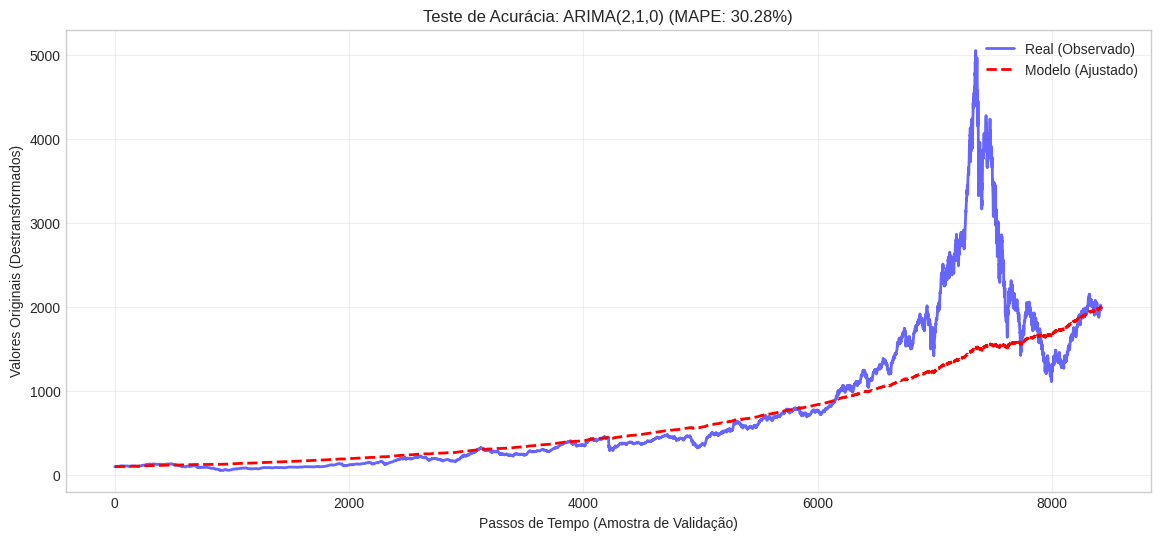

In [5]:
# ==============================================================================
# BLOCO 5: VALIDAÇÃO DE ACURÁCIA (REAL vs MODELO)
# ==============================================================================
print("\n" + "="*80)
print(" BLOCO 5: TESTE DE ACURÁCIA (Real vs Ajustado)")
print("="*80)

if 'melhor_modelo' not in locals():
    print(" Execute os blocos anteriores primeiro.")
else:
    m = melhor_modelo

    # 1. Recuperar a série diferenciada e os resíduos
    # Precisamos alinhar os tamanhos, pois o modelo perde dados no início (pelo d e lags)
    ts_diff = diferenciar_serie(serie_trabalho, ordem=m['d'])
    residuos = m['residuos']

    # O tamanho dos resíduos é menor que a série original devido ao 'p' e 'q'
    # Vamos alinhar pelo final
    tamanho_validacao = len(residuos)
    ts_diff_recorte = ts_diff[-tamanho_validacao:]

    # 2. Reconstruir a Série Diferenciada (Previsto = Real - Resíduo)
    # Na matemática: Resíduo = Real - Previsto  =>  Previsto = Real - Resíduo
    diff_previsto = ts_diff_recorte - residuos

    # 3. Reconstruir a Série Original (Integração)
    # Reverter a diferenciação é complexo sem a série original base.
    # Vamos comparar apenas no domínio transformado (Log) para simplificar a visualização manual
    # ou tentar reconstruir passo a passo a partir do índice correto.

    # Vamos pegar a série de trabalho (Logada) original para alinhar
    # A série 'diff' perde m['d'] pontos. O modelo perde mais max(p,q) pontos.
    inicio_validacao = len(serie_trabalho) - tamanho_validacao
    original_log_recorte = serie_trabalho[inicio_validacao:]

    # Reconstrução Cumulativa (Simplificada para d=1)
    if m['d'] == 1:
        # Pega o valor anterior ao início da validação para servir de base
        base = serie_trabalho[inicio_validacao - 1]
        # A previsão acumulada é a soma cumulativa das diferenças previstas + base
        previsto_log = base + np.cumsum(diff_previsto)
    elif m['d'] == 2:
        # Para d=2 é mais complexo reconstruir manualmente neste script compacto,
        # então vamos comparar as Diferenças (Velocidade/Aceleração) que já é útil.
        print(" Para d=2, exibiremos a comparação na escala diferenciada.")
        original_log_recorte = ts_diff_recorte
        previsto_log = diff_previsto
    else:
        # Caso d=0
        previsto_log = diff_previsto

    # 4. Reverter Log (se foi aplicado)
    # Se 'sucesso_log' for True (variável do Bloco 2), aplicamos exp
    if 'sucesso_log' in locals() and sucesso_log:
        valores_reais = np.exp(original_log_recorte)
        valores_previstos = np.exp(previsto_log)
        label_y = "Valores Originais (Destransformados)"
    else:
        valores_reais = original_log_recorte
        valores_previstos = previsto_log
        label_y = "Valores Originais"

    # 5. Métricas de Erro
    # RMSE (Raiz do Erro Quadrático Médio) - Na mesma unidade dos dados
    rmse = np.sqrt(np.mean((valores_reais - valores_previstos)**2))

    # MAPE (Erro Percentual Médio Absoluto)
    # Evita divisão por zero
    mask = valores_reais != 0
    mape = np.mean(np.abs((valores_reais[mask] - valores_previstos[mask]) / valores_reais[mask])) * 100

    print(f"\n RESULTADOS DA VALIDAÇÃO:")
    print(f"   RMSE: {rmse:.4f} (Margem de erro média na unidade da série)")
    print(f"   MAPE: {mape:.2f}% (Erro percentual médio)")

    if mape < 10:
        print("   -> Classificação: Excelente (< 10%)")
    elif mape < 20:
        print("   -> Classificação: Bom (10-20%)")
    elif mape < 50:
        print("   -> Classificação: Razoável (20-50%)")
    else:
        print("   -> Classificação: Ruim (> 50%) - Modelo não capturou a escala corretamente.")

    # 6. Gráfico Final
    plt.figure(figsize=(14, 6))
    plt.plot(valores_reais, label='Real (Observado)', color='blue', alpha=0.6, linewidth=2)
    plt.plot(valores_previstos, label='Modelo (Ajustado)', color='red', linestyle='--', linewidth=2)
    plt.title(f"Teste de Acurácia: {m['modelo']} (MAPE: {mape:.2f}%)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylabel(label_y)
    plt.xlabel("Passos de Tempo (Amostra de Validação)")
    plt.show()